### Importazione librerie e dati

In [4]:
import pandas as pd
import geopandas as gpd
from datetime import time, timedelta, datetime, date 
import contextily as cx
import numpy as np
import json
import numpy as np
from pathlib  import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

#ho cambiato il percorso così da lavorare direttamente nella repo
data_path = Path('.././data/raw')
data_path2 = Path('.././data/external')
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',        
         'NOV-DATA':'SET-nov-2013.csv',
         'DEC-DATA':'SET-dec-2013.csv',
         'SET-lines':'line.csv',
         'inquinamento' :  'APPA_inquinamento_aria_Nov_Dec_2013.csv',
         'meteo': 'meteotrentino-weather-station-data.json'
        }
# dati inquinamento
df_inquinamento= pd.read_csv(data_path2 / files['inquinamento'] , encoding='latin-1')
#pd.unique(df_inquinamento.Inquinante)

#dati griglia provincia trento
with open(data_path / files['grid']) as f:
    grid_json = json.load(f)

grid = gpd.GeoDataFrame(grid_json['features'])

#consumi sulle linee e dati geografici linee
nomi = ['LINESET', 'time', 'consumi']
df_consumi = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
df_linee = pd.read_csv(data_path / files['SET-lines'])

#dati sulle regioni amministrative
with open(data_path / files['adm_reg']) as f:
    adm_json = json.load(f)

gdf_adm = gpd.GeoDataFrame(adm_json['items'])

#dati meteo
with open(data_path / files['meteo'] ) as file:
    dati_meteo_json = json.load(file)
    
meteo_rawdata = pd.DataFrame(dati_meteo_json['features'])

### Aggiusto dati grid

In [5]:
#converto la colonna geometry nel formato Polygon di shapely
grid['geometry'] = grid['geometry'].apply(lambda x:Polygon(x['coordinates'][0]))

#### Questa parte imposta il crs del geoDataFrame ######
# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg
# Set the GeoDataFrame's coordinate system to WGS84
grid.crs = from_epsg(code = 4326)

/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


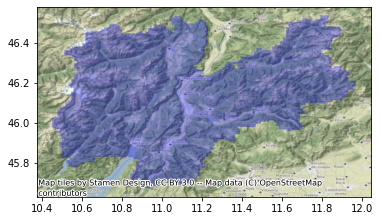

In [6]:
grid['id'] = grid['properties'].apply(lambda x: x['cellId'])
grid.drop(columns=['type', 'properties'], inplace=True) 
axgrid = grid.plot(color='blue', alpha=0.3) #vediamo che la mappa si plotta decentemente
#sovrappongo mappa del trentino
cx.add_basemap(axgrid, crs=grid.crs.to_string() ) 
#per salvare la figura
#plt.savefig("mappaTrentinoBlu.pdf", bbox_inches='tight' , dpi=300) 

### Prima analisi dei consumi elettrici lordi del mese

In [7]:
#poiché la procedura dovrà essere ripetuta, meglio mettere tutto in una funzione 
def genera_mappa_consumi( datiConsumi, df_linee, grid ):
    ''' Restituisce GeoDataFrame per il plot di una mappa in scala di colore a partire dai dati relativi ai consumi.
        Inputs:
            
            datiConsumi:pd.DataFrame che contiene colonna con i codici di linea (LINESET) e i rispettivi consumi
            registrati in un certo giorno e orario.
            
            df_linee: pd.DataFrame che contiene: codici linea, celle per cui passa la linea,
            e nr. di utenze in quella cella.
            
            grid: gpd.GeoDataFrame che contiene le celle in cui è suddiviso il territorio come istanze della classe
                  Polygon (from shapely.geometry)
            
         Returns: 
         
            df_mappa: gpd.GeoDataFrame con il consumo totale su ogni cella del territorio trentino. 
            Totale nel senso di sommato su tutto il periodo del DataFrame datiConsumi .
         '''
    #contiamo le ubicazioni per linea
    df_ubi_per_line = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
    #contiamo i consumi per linea
    df_con_per_line = pd.DataFrame( datiConsumi.groupby('LINESET')['consumi'].sum() ).reset_index()
    #uniamo i due dataframe
    df_consperub = pd.merge(left = df_con_per_line, right = df_ubi_per_line, how = 'outer',on='LINESET' )
    df_consperub = df_consperub.fillna(0)
    #calcolo dei consumi per ubicazione
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    #unisco al dataframe con le linee e le rispettive celle
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET')
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    #sommo i consumi della stessa cella (diverse linee)
    df_cons_per_cella = pd.DataFrame(df_cons_per_cella.groupby('SQUAREID')['consumo_per_cella'].sum() ).reset_index()
    #finalmente unisco tutto al dataframe della mappa che viene ritornato
    df_mappa = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID')
    df_mappa['consumo_per_cella'] = df_mappa['consumo_per_cella'].fillna(0)
    return df_mappa
    

In [8]:
#questa riga di codice serve per vedere se ci sono linee che passano in celle ma non hanno consumo, perchè evidentemente non hanno ubicazioni 
#spoiler nel dataset di novembre ce ne sono ben 37
#per ora abbandoniamo l'idea di un plot in scala logaritmica
#sum(df_mappa.consumo_per_cella == 0)

# tentativo di fare una scala logaritmica 
#df_mappa['log_consumi'] = np.log(df_mappa['consumo_per_cella'])
#mynorm = mpl.colors.LogNorm(vmin=np.nanmin(df_mappa.iloc[:,5].values) ,vmax=df_mappa['consumo_per_cella'].max() )
#df_mappa.plot('consumo_per_cella', cmap = 'YlOrRd', norm=mynorm)
#df_mappa['consumo_per_cella'].min()


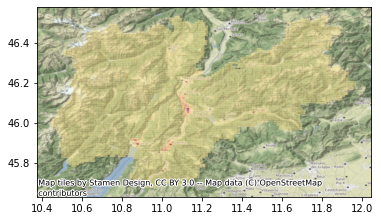

In [9]:
gdf_consumi_lordi = genera_mappa_consumi(df_consumi, df_linee, grid) 
ax_consumi_lordi = gdf_consumi_lordi.plot('consumo_per_cella', cmap='YlOrRd', alpha=0.5) 
cx.add_basemap(ax_consumi_lordi, crs=grid.crs.to_string() ) 

### Indagine sulle variazioni di consumi tra giorno e notte

In [10]:
# abbiamo diviso la colonna time in data e ora per riuscire a gestire meglio i dati
#df_consumi[['Date', 'hour']] =df_consumi['time'].str.split(' ', expand=True)
# divido le celle 
df_consumi[['giorno','ora']] = df_consumi.time.str.split(" ",expand=True)
df_consumi.time = df_consumi.time.apply(datetime.fromisoformat)

#NOTA BENE: SI PUÒ RISISTEMARE QUESTA PARTE E LA FUNZIONE GENERAMAPPACONSUMI USANDO IL FORMATO DATETIME DI PANDAS
#df_consumi['datetime'] = pd.to_datetime(df_consumi['time'], format='%Y-%m-%d %H:%M')
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
mask = ( pd.to_timedelta(df_consumi['ora'].astype(str).add(':00')).between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')) )
df_consumidiurni = df_consumi[mask]
df_consuminotturni = df_consumi[~mask]
#vogliamo arrivare alla loro differenza (normalizzata sul numero di ore!)

In [11]:
df_mappa_giorno = genera_mappa_consumi( df_consumidiurni, df_linee , grid)
df_mappa_notte = genera_mappa_consumi( df_consuminotturni, df_linee, grid)
#normalizzo i consumi per numero di ore nella giornata
df_mappa_giorno['consumo_per_cella']/=11
df_mappa_notte['consumo_per_cella']/=13
#df_mappa_giorno.head(40) #3762.252046
#df_mappa_notte#df_mappa_generale.head(40) #3762.25204
#df_mappa_generale = plotmap( df_consumi, df_linee, grid)

In [12]:
df_mappa_diff = df_mappa_giorno.copy()
df_mappa_diff['consumo_per_cella'] = -df_mappa_giorno['consumo_per_cella'] + df_mappa_notte['consumo_per_cella']

(45.84, 46.2)

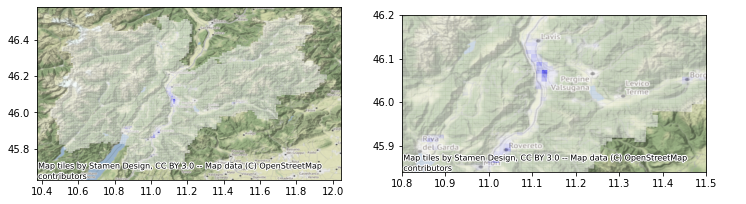

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,5) ) 
MAX = np.max(np.abs(df_mappa_diff['consumo_per_cella'] )  ) 
norm= plt.Normalize( -MAX, MAX ) 
#bwr: blue white red (in ordine crescente)
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[0], norm=norm) 
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[1], norm=norm) 
cx.add_basemap(axes[0], crs=grid.crs.to_string() )
cx.add_basemap(axes[1], crs=grid.crs.to_string() )
axes[1].set_xlim(10.8, 11.5) 
axes[1].set_ylim(45.84, 46.2)

In [14]:
# ho aggiunto una colonna che mi enumera i giorni della settimana 
df_consumi["giorno"] = pd.to_datetime(df_consumi["giorno"])
df_consumi["DayOfWeek"] = df_consumi["giorno"].dt.weekday
# ho aggiunto un altra colonna che mi dice se il giorno è un week end o meno
df_consumi["isweekend"] = df_consumi["giorno"].dt.weekday > 4
# creazione di due database filtrando con la condizione sulla colonna DayOfweek molto più comoda di isweekend 
df_consumisettimana = df_consumi[df_consumi.DayOfWeek < 5]
df_consumiweekend = df_consumi[df_consumi.DayOfWeek > 4]
Nset = len(df_consumisettimana.index)
Ntot = len(df_consumi.index)

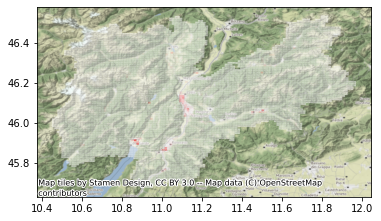

In [15]:
df_mappa_settimana = genera_mappa_consumi( df_consumisettimana, df_linee , grid)
df_mappa_weekend = genera_mappa_consumi( df_consumiweekend, df_linee, grid)
#normalizzo
df_mappa_settimana['consumo_per_cella']/=Nset*144
df_mappa_weekend['consumo_per_cella']/=(Ntot-Nset)*144
# ci sono 144 righe ogni giorno (ogni riga è un quarto d'ora)
df_mappa_diff2 = df_mappa_settimana.copy()
df_mappa_diff2['consumo_per_cella'] = df_mappa_settimana['consumo_per_cella']-df_mappa_weekend['consumo_per_cella']
MAX = np.max(np.abs(df_mappa_diff2['consumo_per_cella'] )  ) 
norm= plt.Normalize( -MAX, MAX )
axs_diff2 = df_mappa_diff2.plot('consumo_per_cella', cmap='bwr', alpha=0.5, norm=norm) 
cx.add_basemap(axs_diff2, crs=grid.crs.to_string() )


# QUI INIZIA UNA PARTE DI NOTEBOOK DA AGGIUSTARE

Nota di giammi: ho scoperto che risulta assai comodo, per gestire gli istanti temporali, usare il formato datetime di pandas, che contiene info precise su : giorno e ora (fino ai millisecondi). La classe è costruita in modo furbo. P.es. se voglio solo l'ora basta _colonna.dt.hour_ oppure voglio sapere che giorno della settimana è uso _colonna.dt.weekday_ . Sarà necessario aggiustare i comandi nella cella seguente.

In [16]:
#from shapely.geometry import Point
#
#gdf_adm['geometry'][0]['coordinates'][0][0][0]
#punto = Point(  gdf_adm['geometry'][0]['coordinates'][0][0][0],gdf_adm['geometry'][0]['coordinates'][0][0][1]     ) 
##gdf_adm['geometry'] = gdf_adm['geometry'].dropna()
##gdf_adm = gdf_adm['geometry'].apply(lambda x:Point(  x['coordinates'][0][0][0],x['coordinates'][0][0][1]     ) )
##gdf_adm.explore()
##print(punto)
#
#gdf_adm.columns
#
##gdf_comuni = gpd.GeoDataFrame( data=[gdf_adm['name'], gdf_adm['geometry']  ], index=gdf_adm.index ) 
#gdf_comuni = gdf_adm[['name','geometry']]
#gdf_comuni
#dgrouped = gdf_comuni.groupby('name')['geometry'].sum()
#gdf_com = pd.DataFrame(dgrouped)
#gdf_com = gdf_com.reset_index()
#gdf_com = gdf_com[gdf_com.geometry != 0]
#print(gdf_com)
## uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
#maskday = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
#          .between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')))
#maskevening = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
#          .between(pd.Timedelta('19:00:00'), pd.Timedelta('24:00:00')))
#df_consumiday = df_consumi[maskday]
#df_consumievening = df_consumi[maskevening]
#df_consumiday = df_consumiday[df_consumiday.DayOfWeek < 5]
#df_consumiday
#df_consumievening = df_consumievening[df_consumievening.DayOfWeek < 5]
#df_consumievening
#def calcolaconsumi( datiConsumi, df_linee, grid ):
#    ''' Plotta una mappa in scala di colore a partire dai dati relativi ai consumi (descrizione da completare)'''
#    dgrouped1 = df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()
#    df_ubi = pd.DataFrame(dgrouped1)
#    ##print(df_ubi)
#    dgrouped = datiConsumi.groupby(['LINESET', 'giorno'])['consumi'].sum()
#    df_con1 = pd.DataFrame(dgrouped)
#    df_con1 = df_con1.reset_index()
#    ##print(df_con1)
#    #df_con1['giorno'] = df_con1['giorno'].apply(date.fromisoformat)
#    df_consperub = pd.merge(left = df_con1, right = df_ubi, how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
#    #print(df_consperub.isna().sum()) avevo provato a contare i nan 
#    # non curiamo i nan perchè causano problemi nel groupby
#    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
#    ##print(df_consperub)
#    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','giorno','cons_per_ubi']], how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
#    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
#    ##print(df_cons_per_cella.dtypes)
#    #df_cons_per_cella[['solo_giorno','ora']] = df_cons_per_cella.giorno.str.split(" ",expand=True)
#    #df_cons_per_cella['giorno'] = df_cons_per_cella['giorno'].apply(str())
#    ##print(df_cons_per_cella)
#    dgrouped2 = df_cons_per_cella.groupby(['SQUAREID', 'giorno'])['consumo_per_cella'].sum()
#    df_cons_per_cella = pd.DataFrame(dgrouped2)
#    df_cons_per_cella = df_cons_per_cella.reset_index()
#    ##print(df_cons_per_cella)
#    #df_mappa_ = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
#    #df_mappa_['consumo_per_cella'] = df_mappa_['consumo_per_cella'].fillna(0)
#    return df_cons_per_cella
#
#df_datidaclassificaregiorno = calcolaconsumi(df_consumiday , df_linee, grid )
#df_datidaclassificaregiorno
#df_datidaclassificaresera = calcolaconsumi(df_consumievening, df_linee, grid )
#df_datidaclassificaresera
#    

### Riordiniamo i dati meteo

In [17]:
#convertiamo la colonna geometry nel formato di shapely
meteo_rawdata['geomPoint.geom'] = meteo_rawdata['geomPoint.geom'].apply(lambda x:Point(x['coordinates']) )
meteo_rawdata.rename(columns={'geomPoint.geom':'geometry'} , inplace=True) 
columnlist = meteo_rawdata.columns.tolist()
meteo_rawdata = meteo_rawdata.melt( id_vars=columnlist[:10]) 
#aggiusto la colonna degli orari
meteo_rawdata[['variable', 'rawtime']] = meteo_rawdata['variable'].str.split('.', expand=True) 
meteo_rawdata['datetime'] = pd.to_datetime( meteo_rawdata['date']+meteo_rawdata['rawtime'], format='%Y-%m-%d%H%M' ) 
#e butto quelle vecchie
meteo_rawdata.drop(columns=['rawtime','date'], inplace=True)
#creo un df temporaneo per riorganizzare la colonna con temperature, vento e precipitazioni
temp_df = meteo_rawdata[['station', 'datetime', 'variable', 'value']]
#questo pivot() mi permette di ottenere tre distinte colonne con i valori che mi interessano
temp_df = temp_df.pivot(index=['station', 'datetime'], columns='variable', values='value').reset_index() 
#unisco il df con le tre nuove colonne a quello con i dati raw
meteo_df = pd.merge(left=meteo_rawdata, right=temp_df, how='right', on=['station', 'datetime'] ) 
meteo_df = meteo_df[meteo_df.variable=='temperatures']
#come ultima cosa separo in due la colonna del vento
meteo_df[['winds', 'windDir']] = meteo_df['winds'].str.split('@', expand=True) 
meteo_df.rename(columns={'winds':'windSpeed'}, inplace=True  ) 
meteo_df.drop(columns=[ 'variable', 'value', 'timestamp' ], inplace=True ) 
#butto le colonne ora inutili
meteo_df.reset_index(inplace=True)
meteo_df.drop(columns='index', inplace=True) 

#meteo_df


### Guardiamo come le stazioni meteo sono distribuite sul territorio (18 giugno)

<AxesSubplot:>

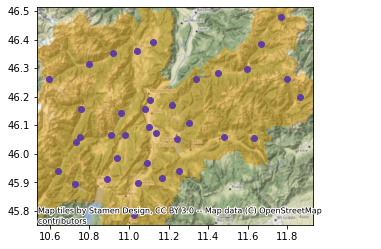

In [18]:
df_mappa_stazioni = meteo_df[['station', 'geometry']]
#df_mappa_stazioni = df_mappa_stazioni.loc[df_mappa_stazioni.astype(str).drop_duplicates().index]
#df_mappa_stazioni.reset_index(inplace=True)
#df_mappa_stazioni.drop(columns='index', inplace=True)
df_mappa_stazioni = gpd.GeoDataFrame(df_mappa_stazioni, crs='EPSG:4326')
df_mappa_stazioni = df_mappa_stazioni.drop_duplicates().reset_index().drop(columns='index')
axmappastazioni = df_mappa_stazioni.plot(color='blue') 
cx.add_basemap(axmappastazioni, crs=df_mappa_stazioni.crs.to_string() ) 
grid.plot(ax=axmappastazioni, color='orange', alpha=0.4) 


## Piano di lavoro per classificazione e regressione

### Obbiettivo: ricavare un dataframe con le seguenti colonne:<br>ZONA, DATA, FASCIAORARIA, PRECIPITAZIONI, TEMPERATURA MEDIA, FLUTTUAZIONITEMPERATURA, VENTO(?), CONSUMOALLORA, CATEGORIA DI CONSUMO

#### Prima si aggiustano i dati meteo così:

1. Divido i dati nelle due fasce orarie di interesse (8-19 e 19-24). 
2. Calcolo le precipitazioni totali in ogni fascia oraria, la temperatura media (volendo, la corrispondente deviazione standard, non lo faccio però perché non mi aspetto sia significativo) e le precipitazioni totali.
7. Posso anche provare a calcolare una media dell'intensità del vento, ma il dato sul vento sembrerebbe inutile. Come tratto la direzione? Sospetto sia irrilevante. Visto che non tutte le stazioni meteo registrano il vento, decido che non considero il vento come feature di interesse, almeno in prima battuta.

#### Poi si divide il territorio trentino in zone (utile per quando si farà analisi su tutto il trentino) al fine di raggrupare i dati dei consumi 

1. Assegnare un set di celle ad ogni stazione meteo, purché i consumi siano significativi in quella zona. Per farlo si procede così (pare la cosa più naturale):

    + Per ogni cella del territorio si calcola la distanza tra il suo centro e ogni stazione meteo.
    + Si associa la cella alla stazione meteo più vicina

2. Creare un dataframe con celle, giorno, fasciaoraria(A-B), consumoorario

3. Raggruppare le celle in base alle zone definite al punto (1) e sommare i loro consumi (groupby)

4. Plottare un'istogramma / fare piccola analisi statistica della distribuzione dei consumi nei vari giorni per individuare buoni range per distinguere categorie di consumo (BASSO/MEDIO/ALTO), es. quartili

5. Creare una nuova colonna CATEGORIA CONSUMO

6. Unire il dataframe ottenuto a quello dei dati meteo



In [19]:
#### Creo funzione per assegnare ad ogni dataframe con dataeora delle ulteriori colonne, che mi dicono: 
#    Il giorno della settimana
#    La fascia oraria ('giorno', 'sera') 

def categorizza_tempo( df ):
    ''' Categorizza la serie temporale di un dataframe. 
        Prende in input un pd.DataFrame che deve avere una colonna 'datetime' nel formato datetime di pandas. Restituisce un dataframe con aggiunte le colonne:
        'TimeRange': 'day' se l'orario è tra le 8:00 (Incluse) e le 19:00 (escluse)
                     'evening' se tra le 19:00 (incluse) e le 24:00(escluse) 
                     'night' negli altri casi
        'isWeekend': bool che identifica se il giorno della settimana è weekend o meno '''
    
    #divido le fasce orarie
    df.loc[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 19), 'TimeRange'] = 'day'
    df.loc[(df['datetime'].dt.hour >= 19) & (df['datetime'].dt.hour < 24), 'TimeRange'] = 'evening'
    df['TimeRange'].fillna('night', inplace=True) 
    
    #distinguo giorni della settimana
    df.loc[df['datetime'].dt.weekday >=5, 'isWeekend'] = True
    df['isWeekend'].fillna(False, inplace=True)
    return df
    
    

### Elaborazione dati meteo per fascia oraria

In [20]:
meteo_df = categorizza_tempo(meteo_df)
#volendo rimpiazzare i vuoti con dei NaN, ma per ora non serve
#meteo_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

#creo due pd.Series che contengono dati raggruppati e mediati/sommati come voglio
meantemp_gb = meteo_df.groupby(['station', meteo_df['datetime'].dt.date,'TimeRange'] )['temperatures'].mean() 
sumprec_gb = meteo_df.groupby(['station', meteo_df['datetime'].dt.date, 'TimeRange'] )['precipitations'].sum() 

#ignoro il vento, che probabilmente è irrilevante e non è rilevato da tutte le stazioni
#meanwind_gb = meteo_df.groupby(['station', 'TimeRange', meteo_df['datetime'].dt.date] )['windSpeed'].mean() 

# unisco in un dataframe e lo aggiusto
dicttmp = { 'meanTemperature': meantemp_gb, 'precipitations': sumprec_gb}
df_tmp_gb = pd.DataFrame(dicttmp).reset_index()
df_tmp_gb.rename(columns={'datetime':'date'} , inplace=True) 

#voglio unirlo con i dati di geometry, e altri dati giornalieri non usati nel groupby
df_tmp_tomerge = meteo_df[['station', 'geometry','elevation', 'minTemperature', 'maxTemperature', 'datetime', 'isWeekend', 'TimeRange']]
#il seguente comando genera una warning ma a quanto pare è un falso positivo. 
#serve a tenere solo le date e a buttare le ore
df_tmp_tomerge['date'] =df_tmp_tomerge['datetime'].dt.date
#togliendo datetime ho un df con un sacco di righe uguali, le butto con .drop_duplicates()
df_tmp_tomerge.drop(columns='datetime', inplace=True)
df_tmp_tomerge  = df_tmp_tomerge.loc[df_tmp_tomerge.astype(str).drop_duplicates().index].reset_index()
df_tmp_tomerge.drop(columns='index', inplace=True)
#finalmente unisco i due dataframe
meteo_df = pd.merge(left=df_tmp_tomerge, right=df_tmp_gb, on=['station', 'date', 'TimeRange'])

/tmp/ipykernel_14977/3146527804.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp_tomerge['date'] =df_tmp_tomerge['datetime'].dt.date
/tmp/ipykernel_14977/3146527804.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp_tomerge.drop(columns='datetime', inplace=True)


### Associazione delle celle di territorio alla più vicina stazione meteo

* Merge tra dataframes di linee e celle
* Per ognuna delle celle attraversate da almeno una linea, calcolo il centro
* Per ogni centro, calcolo tutte le distanze dalle stazioni meteo e prendo il minimo

In [21]:
gdfLineCells = pd.merge(left=grid, right=df_linee, left_on='id', right_on='SQUAREID', how='right').drop(columns='id')
gdfLineCells[['geometry', 'SQUAREID']].drop_duplicates().reset_index().drop(columns='index')
#per calcolare il criordiniamoentroide è tecnicamente opportuno trasformare coordinate sferiche in km
#anche se non dovrebbe fare molta differenza
gdfLineCells.to_crs(epsg=3035, inplace=True)
gdfLineCells['centroid'] = gdfLineCells['geometry'].centroid
df_mappa_stazioni.to_crs(epsg=3035, inplace=True)



In [22]:
#abbasso il livello della programmazione // approccio bruteforce, 
#con approccio elegante c'è il seguente problema :
#la distanza tra alcuni centroidi e alcune stazioni meteo risulta zero 
#usando df2.geometry.apply(lambda g: df1.distance(g)), probabilmente a causa di errori di arrotondamento
meteo_stations = list(df_mappa_stazioni['geometry']) 
cell_centroids = list(gdfLineCells['centroid'] )
#creo array che conterrà gli indici corrispondenti alle stazioni meteo più vicine a ogni centroide
nearest_ms_to_cells = np.zeros( (len(cell_centroids),) ) 
for i_cell, pt_cell in enumerate(cell_centroids):
    nearest_index = 0
    nearest_distance = pt_cell.distance(meteo_stations[nearest_index])
    for i_st, pt_st in enumerate(meteo_stations):
        current_distance = pt_cell.distance(pt_st)
        if current_distance <nearest_distance:
            
            nearest_distance=current_distance
            nearest_index = i_st
    
    #fatto il loop sulle stazioni meteo, segno qual è la più vicina
    nearest_ms_to_cells[i_cell] = nearest_index
    stationcodes = df_mappa_stazioni['station'].to_list()

#creo una lista tale che l'i-esimo elemento della lista è il codice della stazione meteo 
#più vicina alla i-esima cella di territorio (nell'ordine in cui appaiono nei dataframe sopra)
codelist = [stationcodes[int(nearest_ms_to_cells[ii])] for ii, p in enumerate(nearest_ms_to_cells)]

In [23]:
gdfLineCells['nearestStation'] = codelist

(46.04, 46.14)

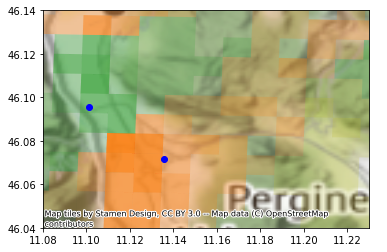

In [41]:
df_mappa_stazioni.to_crs(epsg=4326, inplace=True)
gdfLineCells.to_crs(epsg=4326, inplace=True)
axprova = gdfLineCells.plot('nearestStation', alpha=0.2)
df_mappa_stazioni.plot(color='blue', ax=axprova) 
cx.add_basemap(axprova, crs=df_mappa_stazioni.crs.to_string() ) 

axprova.set_xlim(11.08, 11.23)
axprova.set_ylim(46.04, 46.14)
#plt.savefig('mappaStazioniZone.pdf', dpi=400, bbox_inches='tight') 
#11.13, 46.07


### Creazione di un dataframe con le celle e i rispettivi consumi raggruppati per fascia oraria e tipo di giorno (weekend/infrasett.)

1. Si raggruppano i consumi delle diverse linee per fascia oraria, giorno
2. Conto le celle di ogni linea e poi distribuisco equamente su ciascuna di esse i consumi della linea di ogni giorno e fascia oraria

In [25]:
#sebbene non sia il massimo dell'eleganza, importo di nuovo df_consumi per comodità
#e per evitare conflitti
df_consumi = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
#prima aggiusto la colonna time convertendola nel formato di pandas
df_consumi['time'] = pd.to_datetime(df_consumi['time'], format='%Y-%m-%d %H:%M')
df_consumi.rename(columns={'time':'datetime'}, inplace=True) 
#suddivido in categorie di tempi
df_consumi = categorizza_tempo( df_consumi ) 
#sommo i consumi fissando linea giorno e fascia oraria
gb = df_consumi.groupby(['LINESET', df_consumi.datetime.dt.date, 'TimeRange', 'isWeekend'])['consumi'].sum()
df_consumi = pd.DataFrame(gb).reset_index()
#contiamo le ubicazioni per linea
df_ubi_per_linea = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
df_consumi = pd.merge(left=df_consumi , right=df_ubi_per_linea, on='LINESET', how='left')
#a questo punto le righe di df_consumi corrispondono solo alle linee che hanno avuto dei consumi cioè le linee
# che appaiono nel dataframe di consumi iniziale 
df_consumi.rename(columns={'NR_UBICAZIONI':'TOT_UBICAZIONI'}, inplace=True ) 
#poiché esistono linee nel df_linee dove non sono registrati consumi in df_consumi,
#questo mi da dei nan che decido di ignorare completamente
df_consumi = pd.merge(left=df_consumi, right=df_linee, on='LINESET', how='outer').dropna()
#per ogni cella sommo i consumi di tutte le linee che vi passano
df_consumi['consumo_della_cella'] = df_consumi['consumi']/df_consumi['TOT_UBICAZIONI']*df_consumi['NR_UBICAZIONI']
df_consumi=df_consumi.groupby([ 'SQUAREID','datetime', 'TimeRange', 'isWeekend'])['consumo_della_cella'].sum().reset_index()
### creo un dataframe con SQUAREID e codici stazioni:
df_suddivisione = gdfLineCells[['SQUAREID', 'nearestStation']].drop_duplicates().reset_index().drop(columns='index')
df_consumi = pd.merge(left=df_consumi, right=df_suddivisione, on='SQUAREID', how='left')
df_consumi = df_consumi.groupby(['nearestStation', 'datetime', 'TimeRange', 'isWeekend'])['consumo_della_cella'].sum().reset_index()
df_consumi.rename(columns={'nearestStation':'station', 'datetime':'date', 'consumo_della_cella':'consumoTerritorio'} , inplace=True) 
df_meteo_consumi = pd.merge(left=df_consumi, right=meteo_df, on=['station', 'date', 'TimeRange', 'isWeekend'])
#in ultimo, aggiungo una colonna per indicare quante ubicazioni ci sono in quel territorio
df_ubi_squareid = df_linee.groupby('SQUAREID')['NR_UBICAZIONI'].sum().reset_index()
df_ubi_territori = pd.merge(left=df_ubi_squareid, right=df_suddivisione, on='SQUAREID')
df_ubi_territori = df_ubi_territori.groupby('nearestStation')['NR_UBICAZIONI'].sum().reset_index()
df_ubi_territori.rename(columns={'nearestStation':'station'}, inplace=True) 
df_meteo_consumi = pd.merge(left=df_meteo_consumi, right=df_ubi_territori, how='left', on='station')
df_meteo_consumi['consumo_per_ubicazione'] = df_meteo_consumi['consumoTerritorio']/df_meteo_consumi['NR_UBICAZIONI']


In [57]:
dfTrento = df_meteo_consumi[ (df_meteo_consumi['station']=='T0129') & (df_meteo_consumi['isWeekend']==False) ]

                           

In [58]:
ProfileReport(dfTrento)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

station                   geometry
0    T0032  POINT (11.25372 45.94027)
1    T0071  POINT (10.79583 46.31340)
2    T0074  POINT (10.91841 46.35160)
3    T0096  POINT (11.66458 46.38364)
4    T0101  POINT (11.07973 46.15635)
5    T0118  POINT (11.21802 46.17063)
6    T0129  POINT (11.13565 46.07185)
7    T0135  POINT (11.10131 46.09565)
8    T0139  POINT (11.30223 46.10709)
9    T0146  POINT (11.09174 45.96783)
10   T0147  POINT (11.04379 45.89644)
11   T0175  POINT (10.75748 46.15648)
12   T0179  POINT (10.73088 46.04113)
13   T0182  POINT (10.75168 46.05911)
14   T0189  POINT (10.98028 46.06526)
15   T0210  POINT (11.16435 45.91535)
16   T0236  POINT (11.11886 46.39071)
17   T0360  POINT (10.59682 46.26251)
18   T0367  POINT (11.45171 46.28478)
19   T0379  POINT (10.94137 45.98403)
20   T0383  POINT (10.95756 46.14160)
21   T0389  POINT (11.59825 46.29784)
22   T0392  POINT (11.47748 46.05805)
23   T0397  POINT (11.03990 46.36117)
24   T0401  POINT (10.88713 45.91037)
25   T0402  POINT (10.72503 45.89563)
26   T0405  POINT (11.02374 45.78614)
27   T0408  POINT (11.10461 46.18723)
28   T0409  POINT (11.24035 46.05251)
29   T0414  POINT (10.91133 46.06626)
30   T0419  POINT (11.86602 46.19948)
31   T0428  POINT (10.64241 45.94062)
32   T0431  POINT (11.33626 46.26304)
33   T0437  POINT (11.76685 46.47832)
34   T0450  POINT (11.79625 46.26160)
35   T0469  POINT (11.62991 46.05718)